# Machine Learning Project for the course of ML mod. 1 (2024/2025) of the Bachelor in Artificial Intelligence (UNIPV)

The dataset is taken from https://www.kaggle.com/datasets/hopesb/student-depression-dataset and this project aims to classify students as either depressed or not. The dataset as we can see in the table below contains various features related to demographics, academic performance, lifestyle habits, family history and mental health indicators. 

The target variable, "Depression", is binary (0 for no, 1 for yes), indicating whether a student is experiencing depression. By analyzing these factors, the model seeks to identify patterns that contribute to student depression and improve early detection.

#### Library Imports  

In this block of code, we import all the essential libraries and modules needed for the project. The `Init` file handles the installation of all required modules.

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

from xgboost import XGBClassifier

import missingno as msno
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import warnings
from mlxtend.plotting import plot_decision_regions

warnings.filterwarnings('ignore')

## Loading the Dataset

We load the student depression dataset from a CSV file located at `/work/StudentDepressionDataset.csv`. This dataset contains the data used for the binary classification of depression among students.


In [2]:
data = pd.read_csv("/work/StudentDepressionDataset.csv")

In [3]:
data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


#### Introducing Missing Values

For this ML project, handling missing values was a key requirement. To address this, we intentionally introduced missing values into the dataset. This was done using Python by specifying a missing percentage (10% in this case) and selecting a list of columns where missing values should be introduced. A random sample of rows was then chosen, and the corresponding values were replaced with `NaN` to simulate missing data.
 The `random_state` parameter ensures reproducibility of the random selection.


In [4]:
missing_percentage = 0.1

columns_to_modify = ['Gender', 'City', 'Dietary Habits', 'Degree']
columns_to_modify = [col for col in columns_to_modify if col in data.columns]

for col in columns_to_modify:
    random_indices = data.sample(frac=missing_percentage, random_state=30).index
    data.loc[random_indices, col] = np.nan

## Data Preprocessing

#### Renaming Columns

We rename the dataset columns to shorter, more manageable names for easier reference during analysis. For example, "Academic Pressure" becomes "Academic_pres", and similar abbreviations are applied to other columns.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 25111 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   25111 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [6]:
data = data.rename(columns={
    'Academic Pressure': 'Academic_pres',
    'Study Satisfaction': 'Study_sat',
    'Sleep Duration': 'Sleep_dur',
    'Dietary Habits': 'Diet_habits',
    'Have you ever had suicidal thoughts ?': 'Suic_thought',
    'Work/Study Hours': 'Work_stud_hr',
    'Financial Stress': 'Fin_stress',
    'Family History of Mental Illness': 'Family_hist'
})

#### Evaluating and Removing Irrelevant Features

An analysis of the "Work Pressure" column shows that almost all values are 0.0, with only two entries of 5.0 and one of 2.0, indicating a lack of meaningful variability. Similarly, the "Profession" and "Job Satisfaction" columns do not contribute valuable insights, and the "id" column merely serves as an identifier without any analytical importance.

Based on these observations, we remove these columns from the dataset to simplify our analysis and concentrate on the features that are truly significant for our classification task.


In [7]:
data['Profession'].value_counts()

Profession
Student                   27870
Architect                     8
Teacher                       6
Digital Marketer              3
Chef                          2
Content Writer                2
Pharmacist                    2
Doctor                        2
UX/UI Designer                1
Civil Engineer                1
Manager                       1
Educational Consultant        1
Lawyer                        1
Entrepreneur                  1
Name: count, dtype: int64

In [8]:
data['Work Pressure'].value_counts()

Work Pressure
0.0    27898
5.0        2
2.0        1
Name: count, dtype: int64

In [9]:
data['Job Satisfaction'].value_counts()

Job Satisfaction
0.0    27893
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [10]:
data = data.drop('id', axis=1)
data = data.drop('Profession', axis=1)
data = data.drop('Work Pressure', axis=1)
data = data.drop('Job Satisfaction', axis=1)

#### Handling Infrequent 'Others' Entries

An examination of the value distribution in the 'Degree' column reveals that the category 'Others' appears in only a very small percentage of cases. Similar observations apply to the 'Sleep_dur' and 'Diet_habits' columns. Since these infrequent 'Others' values are not informative, I choose to treat them as missing data by replacing 'Others' with NaN. This allows to handle them consistently during subsequent data cleaning and analysis steps.

It's also important to notice that there is an high quantity of unique values in the 'Degree' column.

In [11]:
data['Sleep_dur'].value_counts()

Sleep_dur
Less than 5 hours    8310
7-8 hours            7346
5-6 hours            6183
More than 8 hours    6044
Others                 18
Name: count, dtype: int64

In [12]:
data['Diet_habits'].value_counts()

Diet_habits
Unhealthy    9302
Moderate     8916
Healthy      6881
Others         12
Name: count, dtype: int64

In [13]:
data['Degree'].value_counts()

Degree
Class 12    5446
B.Ed        1694
B.Com       1359
B.Arch      1336
BCA         1284
MSc         1073
B.Tech      1042
MCA          929
M.Tech       915
BHM          824
BSc          802
M.Ed         744
B.Pharm      736
M.Com        659
BBA          633
MBBS         624
LLB          605
BE           550
BA           541
M.Pharm      524
MD           520
MBA          498
MA           496
PhD          463
LLM          437
ME           173
MHM          173
Others        31
Name: count, dtype: int64

In [14]:
data['Sleep_dur'] = data['Sleep_dur'].replace('Others', np.nan)
data['Diet_habits'] = data['Diet_habits'].replace('Others', np.nan)
data['Degree'] = data['Degree'].replace('Others', np.nan)

#### Handling a High Number of Unique Values  

Earlier, we noticed that the 'Degree' column contained an overwhelming number of unique values. To simplify analysis, I categorized them into broader groups. For example, "BSc" was mapped to "Undergraduate Degree" to make identification easier.  

A similar approach was applied to the 'City' column. I identified common patterns among cities and grouped them into meaningful categories for better organization. Additionally, I discovered several outliers, which I decided to group and convert into NaN values to facilitate better handling later.


In [15]:
degree_mapping = {
    'Pre-University': ['Class 12'],
    'Undergraduate Degree': ['B.Com', 'BBA', 'BSc', 'BCA', 'B.Tech', 'BE', 'B.Pharm', 'BA', 'LLB', 'B.Arch', 'BHM', 'MBBS', 'B.Ed'],
    'Postgraduate Degree': ['M.Com', 'MBA', 'MSc', 'MCA', 'M.Tech', 'ME', 'M.Pharm', 'MA', 'LLM', 'MHM', 'MD', 'M.Ed'],
    'PhD': ['PhD']
}

degree_to_category = {degree: category for category, degrees in degree_mapping.items() for degree in degrees}

data['Degree'] = data['Degree'].map(degree_to_category)

In [16]:
data['Degree'].value_counts()

Degree
Undergraduate Degree    12030
Postgraduate Degree      7141
Pre-University           5446
PhD                       463
Name: count, dtype: int64

In [17]:
data['City'].value_counts()

City
Kalyan                1418
Srinagar              1235
Hyderabad             1209
Vasai-Virar           1154
Lucknow               1034
Thane                 1018
Ludhiana              1006
Agra                   992
Surat                  986
Kolkata                965
Jaipur                 922
Patna                  905
Visakhapatnam          876
Pune                   870
Bhopal                 851
Ahmedabad              849
Chennai                808
Meerut                 743
Rajkot                 732
Bangalore              691
Delhi                  685
Ghaziabad              664
Vadodara               628
Mumbai                 627
Varanasi               618
Nagpur                 588
Indore                 567
Kanpur                 536
Nashik                 494
Faridabad              416
Saanvi                   2
Bhavna                   2
Harsha                   2
Less Delhi               1
M.Tech                   1
3.0                      1
Less than 5 Kalyan     

In [18]:
city_mapping = {
    'Major Metropolitan Cities': [
        'Mumbai', 'Delhi', 'Bangalore', 'Hyderabad', 
        'Kolkata', 'Chennai', 'Ahmedabad', 'Pune'
    ],
    
    'Industrial and Commercial Cities': [
        'Surat', 'Lucknow', 'Jaipur', 'Patna', 'Visakhapatnam', 
        'Bhopal', 'Ludhiana', 'Nagpur', 'Indore', 'Kanpur', 
        'Vadodara', 'Ghaziabad', 'Faridabad'
    ],
    
    'Suburban & Satellite Cities': [
        'Thane', 'Vasai-Virar', 'Kalyan', 'Meerut', 'Rajkot', 
        'Nashik', 'Varanasi'
    ],
    
    'Other Cities': [
        'Agra', 'Srinagar', 'Jaipur'
    ],
    
    'Miscellaneous / Outliers':[
        'Saanvi', 'Bhavna', 'Harsha', 'Less Delhi', 'M.Tech', 
        '3.0', 'Less than 5 Kalyan', 'Mira', 'Gaurav', 'Harsh', 
        'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com', 'Nalyan', 
        'City', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad'
    ]
}

city_to_category = {city: category for category, cities in city_mapping.items() for city in cities}

data['City'] = data['City'].map(city_to_category)
data['City'] = data['City'].replace('Miscellaneous / Outliers', np.nan)

#### Checking for Missing Values

In [19]:
data.isnull().sum(axis=0)

Gender           2790
Age                 0
City             2814
Academic_pres       0
CGPA                0
Study_sat           0
Sleep_dur          18
Diet_habits      2802
Degree           2821
Suic_thought        0
Work_stud_hr        0
Fin_stress          3
Family_hist         0
Depression          0
dtype: int64

<AxesSubplot: >

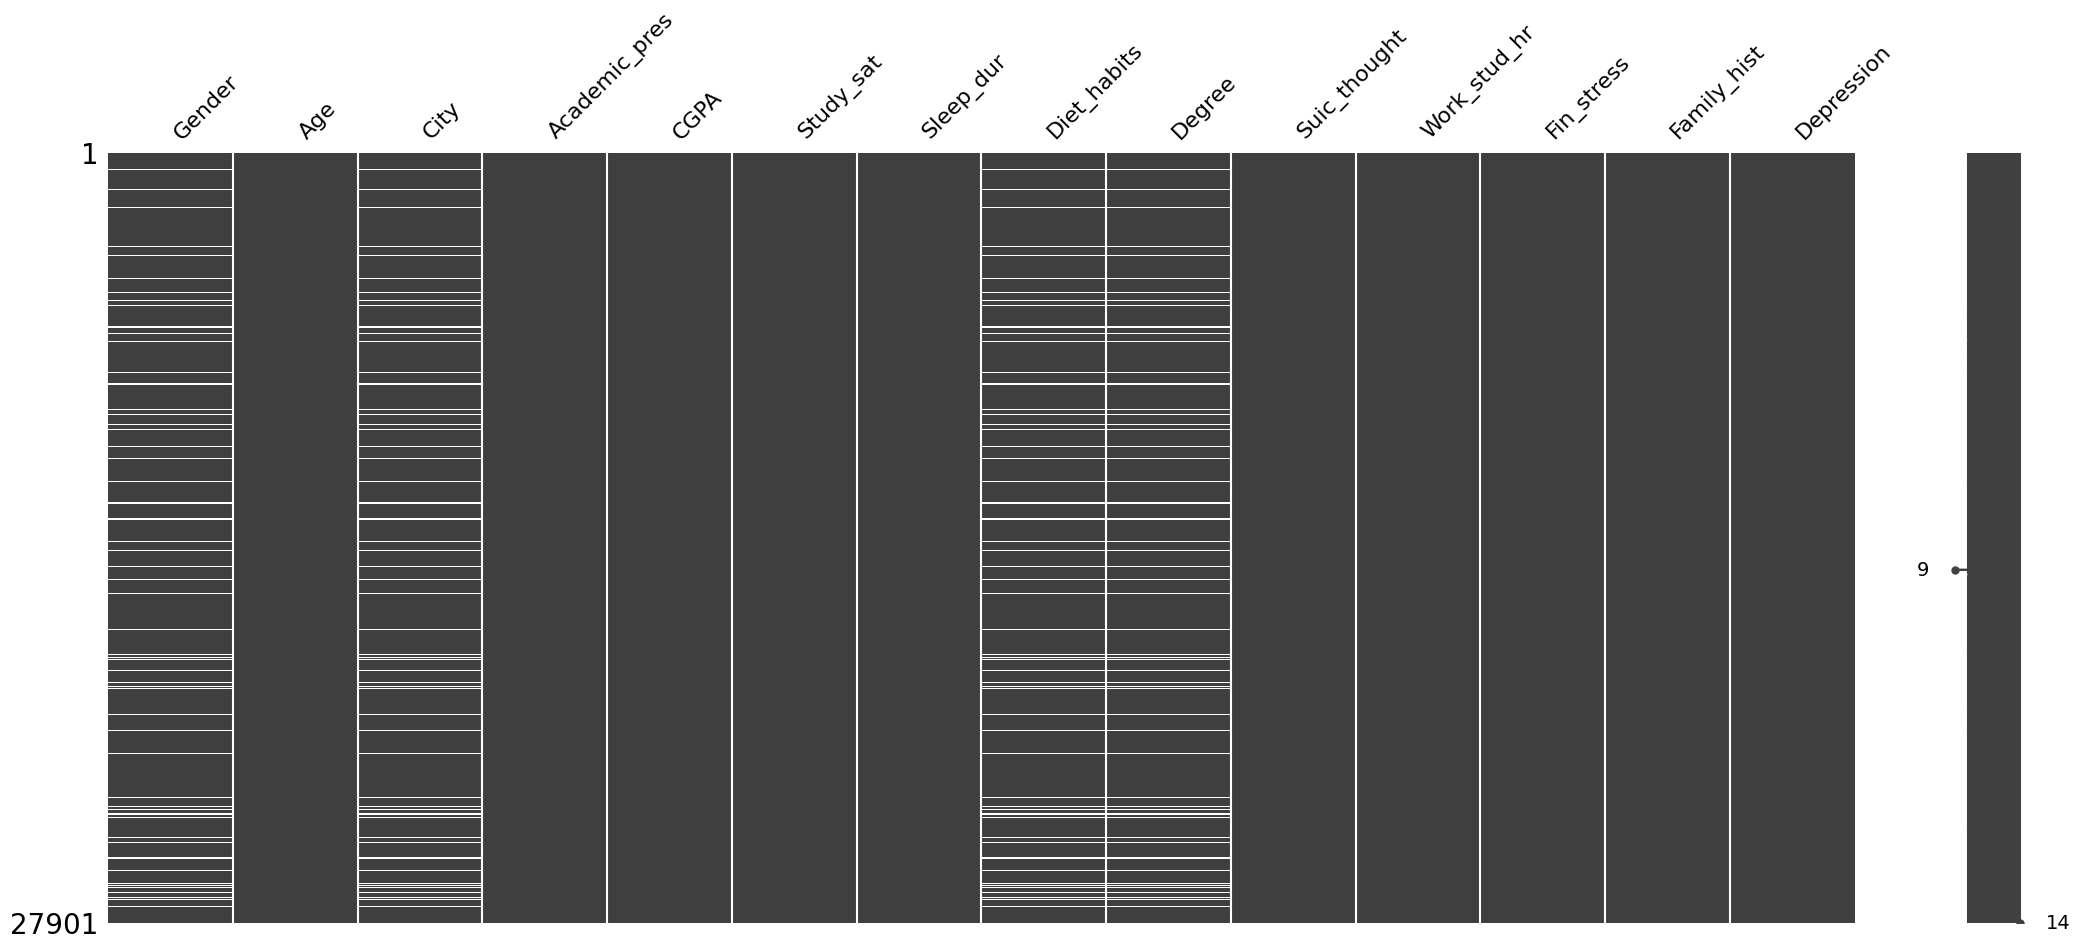

In [20]:
msno.matrix(data)

#### Removing Rows with Missing Values in 'Fin_stress' and 'Sleep_dur'

In this step, we remove rows with missing values specifically in the 'Fin_stress' and 'Sleep_dur' columns. This decision is based on the fact that these two features contain only a very small percentage of missing data. Dropping these rows has a negligible impact on the dataset.
For the other columns that contain missing data, we will handle them later.

In [21]:
data = data.dropna(subset=['Fin_stress'])
data = data.dropna(subset=['Sleep_dur'])

This dataset is now ready for building the binary classification model to predict student depression.

In [22]:
data

,Gender,Age,City,Academic_pres,CGPA,Study_sat,Sleep_dur,Diet_habits,Degree,Suic_thought,Work_stud_hr,Fin_stress,Family_hist,Depression
0,Male,33.0,Industrial and Commercial Cities,5.0,8.97,2.0,5-6 hours,Healthy,Undergraduate Degree,Yes,3.0,1.0,No,1
1,Female,24.0,Major Metropolitan Cities,2.0,5.90,5.0,5-6 hours,Moderate,Undergraduate Degree,No,3.0,2.0,Yes,0
2,Male,31.0,Other Cities,3.0,7.03,5.0,Less than 5 hours,Healthy,Undergraduate Degree,No,9.0,1.0,Yes,0
3,Female,28.0,Suburban & Satellite Cities,3.0,5.59,2.0,7-8 hours,Moderate,Undergraduate Degree,Yes,4.0,5.0,Yes,1
4,NaN,25.0,NaN,4.0,8.13,3.0,5-6 hours,NaN,NaN,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27.0,Industrial and Commercial Cities,5.0,5.75,5.0,5-6 hours,Unhealthy,Pre-University,Yes,7.0,1.0,Yes,0
27897,Male,27.0,Industrial and Commercial Cities,2.0,9.40,3.0,Less than 5 hours,Healthy,Postgraduate Degree,No,0.0,3.0,Yes,0
27898,Male,31.0,Industrial and Commercial Cities,3.0,6.61,4.0,5-6 hours,Unhealthy,Postgraduate Degree,No,12.0,2.0,No,0
27899,Female,18.0,Industrial and Commercial Cities,5.0,6.88,2.0,Less than 5 hours,Healthy,Pre-University,Yes,10.0,5.0,No,1


#### Splitting Features and Target

We split the dataset into two parts:

- `X`: Contains all the data except the Depression column. These are the features the model will use to make predictions.
- `y`: Contains only the Depression column, which is what we want the model to predict.

In [23]:
X = data.drop('Depression',axis=1)
y = data['Depression']

#### Building Data Preprocessing Pipelines

In this section, we define multiple pipelines to handle different types of features based on their data characteristics. Each pipeline consists of a sequence of transformations, and we combine them using a ColumnTransformer.

#### Final Transformation with ColumnTransformer

All the pipelines are integrated into a `ColumnTransformer` called `final_transformation`, which applies the appropriate pipeline to each feature.
This setup ensures that each feature is preprocessed correctly before being fed into the machine learning models.

In [24]:
pipeline_numerical = Pipeline(
    [
    ('scaler', StandardScaler() )
    ])

pipeline_gender_city_degree = Pipeline(
    [
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
    ])

pipeline_binary = Pipeline(
    [
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
    ])

pipeline_sleep = Pipeline(
    [
        ('ordinal_sleep', OrdinalEncoder(categories=[['Less than 5 hours', '7-8 hours', '5-6 hours', 'More than 8 hours']])),
        ('scaler_sleep', StandardScaler())
    ])

pipeline_diet = Pipeline(
    [
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ordinal_diet', OrdinalEncoder(categories=[['Unhealthy', 'Moderate', 'Healthy']])),
        ('scaler_diet', StandardScaler())
    ])

final_transformation = ColumnTransformer(transformers=[
    ('Gender', pipeline_gender_city_degree ,['Gender']),
    ('Suic_thought', pipeline_binary ,['Suic_thought']),
    ('Family_hist', pipeline_binary ,['Family_hist']),
    ('Age', pipeline_numerical ,['Age']),
    ('Academic_pres', pipeline_numerical ,['Academic_pres']),
    ('CGPA', pipeline_numerical ,['CGPA']),
    ('Study_sat', pipeline_numerical ,['Study_sat']),
    ('Work_stud_hr', pipeline_numerical ,['Work_stud_hr']),
    ('Fin_stress', pipeline_numerical ,['Fin_stress']),
    ('Degree', pipeline_gender_city_degree ,['Degree']),
    ('Sleep_dur', pipeline_sleep ,['Sleep_dur']),
    ('City', pipeline_gender_city_degree ,['City']),
    ('Diet_habits', pipeline_diet ,['Diet_habits']),
    ],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

## Splitting the Dataset into Training and Testing Sets

We split the dataset into training and testing sets using the `train_test_split` function.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

#### Creating the Model Pipeline

Now we are creating the `model_pipeline` using the IMBPipeline to handle the slight imbalance in the target variable. 
It’s important to note that this is just the formal structure of the model_pipeline. The final configuration, including the selection and tuning of different models, will be performed later.


In [26]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

We run the `fit` method and the `predict` to verify if errors occur.

In [27]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('Gender',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('Suic_thought',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Suic_thought']),
                                                 ('Family_hist'...
                                                                                 handle_unknown='ignore'))]),
                                                  ['City']),
                                                 ('Diet_habits',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_diet',
                                                                   OrdinalEncoder(categories=[['Unhealthy',
                                                                                               'Moderate',
                                                                                               'Healthy']])),
                                                                  ('scaler_diet',
                                                                   StandardScaler())]),
                                                  ['Diet_habits'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [28]:
model_pipeline.predict(X_test)

array([0, 0, 1, ..., 1, 1, 1])

#### Configuring Hyperparameter Search for Model Optimization

In this section, we define multiple configuration sets for samplers, dimensionality reduction techniques, and classifiers. These configurations will be used in hyperparameter optimization processes such as Randomized Grid Search to systematically explore different model settings. The goal is to identify the best combination of samplers, dimensionality reduction techniques, and classifiers to maximize model performance.


In [29]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9, 0.95, 0.99]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,1000),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10, 50, 100, 500]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [50, 100, 200, 500],
        'classifier__learning_rate': loguniform(0.001, 0.01, 0.1),
        'classifier__max_depth': [3, 5, 7]
    }
]

In [30]:
for configuration in itertools.product(['a','b'],[1,2,3],['Z','W','y']):
    print(configuration)

('a', 1, 'Z')
('a', 1, 'W')
('a', 1, 'y')
('a', 2, 'Z')
('a', 2, 'W')
('a', 2, 'y')
('a', 3, 'Z')
('a', 3, 'W')
('a', 3, 'y')
('b', 1, 'Z')
('b', 1, 'W')
('b', 1, 'y')
('b', 2, 'Z')
('b', 2, 'W')
('b', 2, 'y')
('b', 3, 'Z')
('b', 3, 'W')
('b', 3, 'y')


In [31]:
a = ({'a':1},{'b':2},{'c':3})
dict(itertools.chain(*(e.items() for e in a)))

{'a': 1, 'b': 2, 'c': 3}

#### Generating All Hyperparameter Configurations
In this section, we generate all possible combinations of hyperparameter settings using `itertools.product`.
We generates all possible combinations of the configurations and for each combination, we merge the individual dictionaries (representing sampler, dimensionality reduction, and classifier settings) into a single dictionary.
Each merged dictionary (representing one complete set of hyperparameters) is appended to the `all_configs` list.

In [32]:
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [33]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 48'

In [34]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f86cd29b670>,
  'classifier': [Perceptron()],
  'classifier__max_iter': [1, 5, 10, 15, 50, 100],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f86cd278fa0>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']}]

#### Hyperparameter Optimization with RandomizedSearchCV
Now, we can use nested-cross validation to identify the best candidates to be our reference model. 
In this step, we perform hyperparameter optimization using `RandomizedSearchCV`, which is the inner loop of nested-cross validation. 
We set `cv=2` so it uses 2-fold cross-validation to evaluate model performance for each combination.

In [35]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

## Evaluating the Optimized Model with Cross-Validation

We use the `cross_validate` function to evaluate the performance of the optimized model with 5-fold cross-validation. The F1 score is used as the evaluation metric, and the best estimators from each fold are returned for further analysis. Parallel processing is enabled to speed up the computation, and detailed output is provided to monitor progress. To get the best estimators for each fold, we must set ```return_estimator=True```.

In [36]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3, n_jobs=-1)

[CV] END ......................................., score=0.875 total time=11.8min
[CV] END ......................................., score=0.865 total time=12.9min
[CV] END ......................................., score=0.862 total time=12.7min
[CV] END ......................................., score=0.868 total time=15.8min
[CV] END ......................................., score=0.869 total time=13.8min


The output of ```cross_validate``` is a dictionary providing all the information for each cross-validation iteration:
1. the best estimator returns by the randomized grid search
2. the hyperparameter of the best estimator. 
3. the score on the validation fold for the best estimator.


In [37]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
LinearDiscriminantAnalysis()
LogisticRegression(C=5.960706257635645, penalty='l1', solver='saga') {'C': 5.960706257635645, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.8750474743638436
----------
None
None
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10714552546706513, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_dept

In [38]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.8681628510206383, F1 on test set:0.8809130500075086
F1 on training set:0.8739988719684151, F1 on test set:0.8798437969360168
F1 on training set:0.8682769484659816, F1 on test set:0.8812340871648944
F1 on training set:0.8685864859777903, F1 on test set:0.8799759651494667
F1 on training set:0.8684359119141728, F1 on test set:0.8790844752296341


#### Confusion Matrix for Model Evaluation

In this step, we evaluate the model's performance using a confusion matrix, which provides insights into the classification results by comparing predicted and actual labels.

The `confusion_matrix` function compares the predicted labels (`y_pred`) with the true labels (`y_test`) to generate a matrix. In this case we have two confusion matrix the first is for the train set, while the second is for the test set.

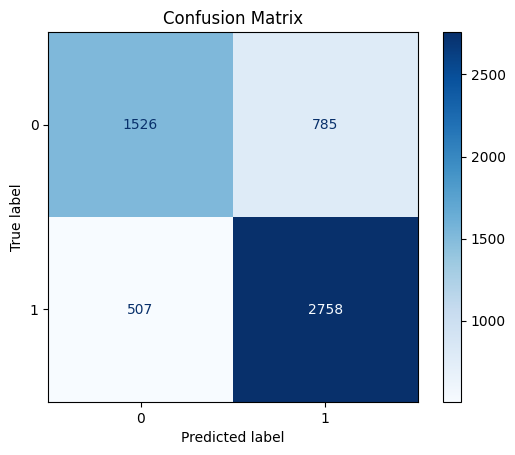

In [40]:
y_pred = model_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

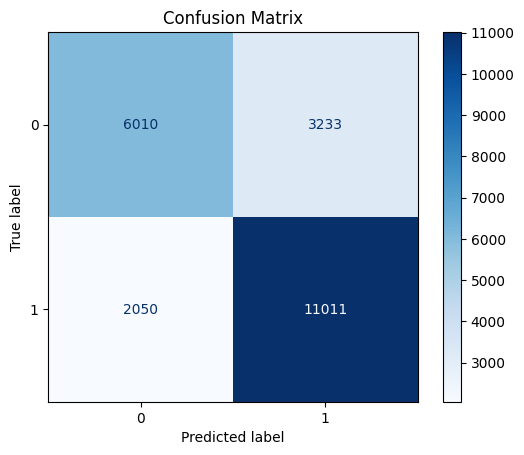

In [39]:
y_train_pred = model_pipeline.predict(X_train)

cm = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### Refinement of the selected model

From the previous we have selected one of the best candidate models. In this final step, we re-run the hyperparameter optmization fixing the modelling apporach and varying the hyperparameters in a range close to selected model's one.

In [41]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('classifier',LogisticRegression(solver='saga', penalty = 'l1'))
])

In [42]:
params = {
    'classifier__C': uniform(loc = 5, scale = 10)
}

In [43]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
    n_iter=20,
    scoring='f1'
)

In [44]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('Gender',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Gender']),
                                                                              ('Suic_thought',
                                                                               Pipeline(ste...
                                                                                                OrdinalEncoder(categories=[['Unhealthy',
                                                                                                                            'Moderate',
                                                                                                                            'Healthy']])),
                                                                                               ('scaler_diet',
                                                                                                StandardScaler())]),
                                                                               ['Diet_habits'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(penalty='l1',
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8722848070>},
                   scoring='f1')

In [45]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('Gender',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('Suic_thought',
                                                  Pipeline(steps=[('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Suic_thought']),
                                                 ('Family_hist'...
                                                                                 handle_unknown='ignore'))]),
                                                  ['City']),
                                                 ('Diet_habits',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_diet',
                                                                   OrdinalEncoder(categories=[['Unhealthy',
                                                                                               'Moderate',
                                                                                               'Healthy']])),
                                                                  ('scaler_diet',
                                                                   StandardScaler())]),
                                                  ['Diet_habits'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=12.840883709612676, penalty='l1',
                                    solver='saga'))])

In [46]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.8790844752296341

In [47]:
accuracy_score(y_test, rs_best.best_estimator_.predict(X_test))

0.8559899569583931

In [48]:
recall_score(y_test, rs_best.best_estimator_.predict(X_test))

0.8940275650842266

In [49]:
precision_score(y_test, rs_best.best_estimator_.predict(X_test))

0.8646327014218009

In [50]:
cls = rs_best.best_estimator_

#### Evaluation of the Learning Curve

In [51]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.84, 0.92)

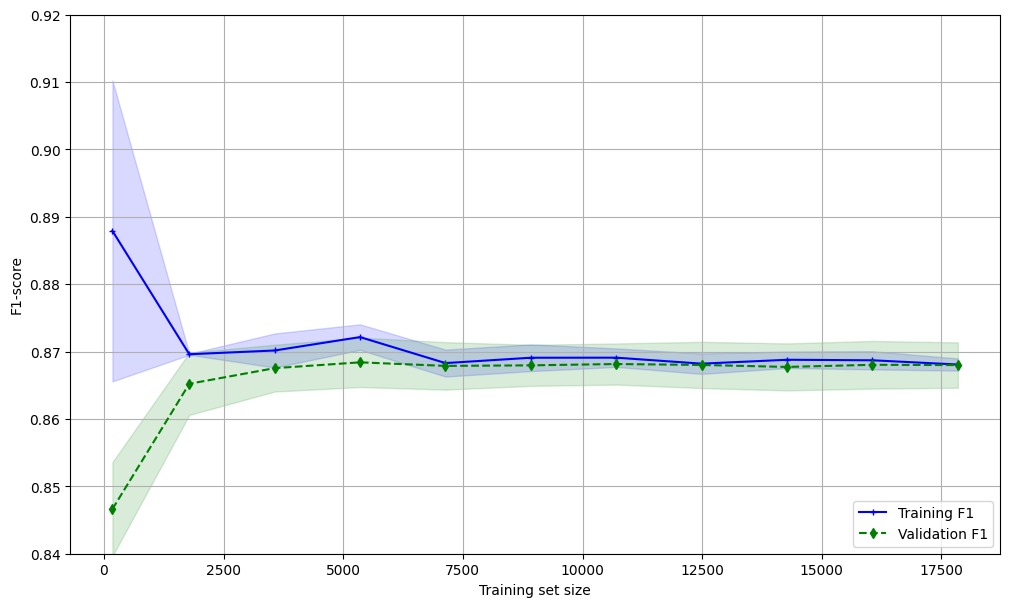

In [52]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.84, 0.92])

#### Evaluation of the Validation Curve

In [53]:
range_C = [0.0001,0.001,0.01,0.1,1,10,100, 1000]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(1e-05, 1050)

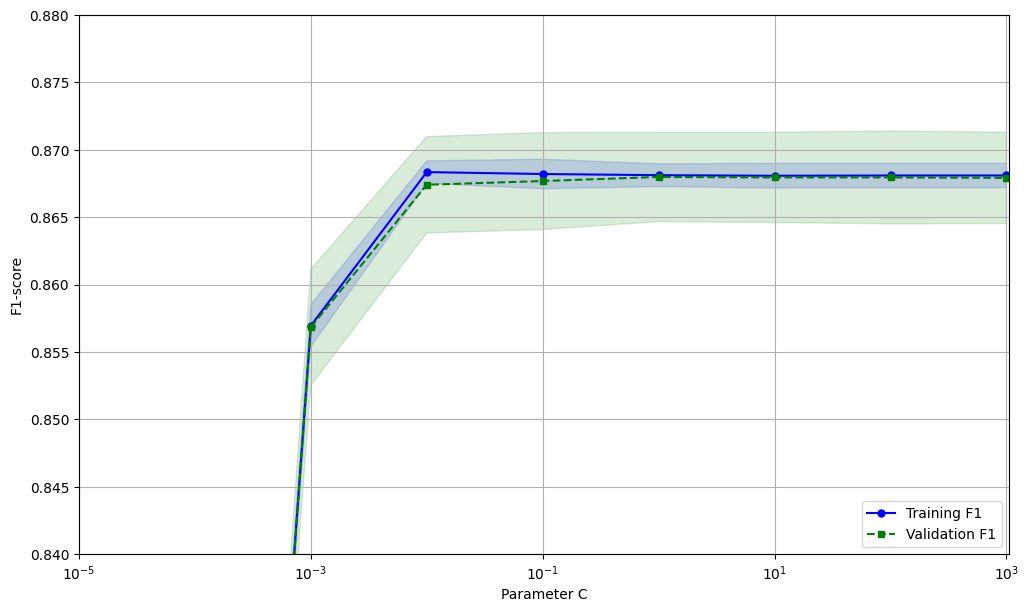

In [54]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.84, 0.88])
ax.set_xscale('log')
ax.set_xlim([0.00001,1050])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1e9da872-d154-4e9a-8a4d-ad545f1b28fd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>